In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

races = pd.read_csv("data_raw/races.csv")
results = pd.read_csv("data_raw/results.csv")
status = pd.read_csv("data_raw/status.csv")
circuits = pd.read_csv("data_raw/circuits.csv")

In [34]:
#CODE FOR MERGING 

#Merge results and races 
merged = pd.merge(
    results[["raceId", "time", "resultId", "fastestLapTime", "statusId"]],
    races[["raceId", "date", "circuitId", "year"]],
    on = "raceId",
    how = "left"
)
#Merge status into results and races 
merged = pd.merge(
    merged,
    status,
    on = "statusId",
    how = "left"
)
#Merge circuits into status, results, and races
merged = pd.merge(
    merged,
    circuits[["name", "circuitId"]],
    on = "circuitId",
    how = "left"
)

#View merged dataset
display(merged)

,raceId,time,resultId,fastestLapTime,statusId,date,circuitId,year,status,name
0,18,1:34:50.616,1,1:27.452,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit
1,18,+5.478,2,1:27.739,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit
2,18,+8.163,3,1:28.090,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit
3,18,+17.181,4,1:28.603,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit
4,18,+18.014,5,1:27.418,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit
...,...,...,...,...,...,...,...,...,...,...
25835,1096,\N,25841,1:29.833,11,2022-11-20,24,2022,+1 Lap,Yas Marina Circuit
25836,1096,\N,25842,1:31.158,11,2022-11-20,24,2022,+1 Lap,Yas Marina Circuit
25837,1096,\N,25843,1:29.788,9,2022-11-20,24,2022,Hydraulics,Yas Marina Circuit
25838,1096,\N,25844,1:30.309,130,2022-11-20,24,2022,Collision damage,Yas Marina Circuit


In [35]:
#CODE FOR CLEANING

#Remove Monaco Grand Pix from data 
merged = merged.query("name != 'Circuit de Monaco'")

#Filtering for only drivers who finished the race 
merged = merged.query("status == 'Finished'")

#Get rid of NAs in fastest lap time variable
merged = merged.query("fastestLapTime != '\\\\N'")

#Converting fastest lap time to date time so numerical anaylsis can be completed
merged["fastestLapTime"] = pd.to_datetime(
    merged["fastestLapTime"],
    format = "%M:%S.%f"
)
merged["fastestLapTime"] = merged["fastestLapTime"] - pd.to_datetime("1900-01-01 00:00:00.000")

merged['date'] = pd.to_datetime(merged['date'])

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else: # months 9, 10, 11
        return 'Fall'
    
merged['Season'] = merged['date'].dt.month.apply(month_to_season)

merged['year'] = merged["date"].dt.year

#View merged dataset after cleaning
display(merged)

,raceId,time,resultId,fastestLapTime,statusId,date,circuitId,year,status,name,Season
0,18,1:34:50.616,1,0 days 00:01:27.452000,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit,Spring
1,18,+5.478,2,0 days 00:01:27.739000,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit,Spring
2,18,+8.163,3,0 days 00:01:28.090000,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit,Spring
3,18,+17.181,4,0 days 00:01:28.603000,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit,Spring
4,18,+18.014,5,0 days 00:01:27.418000,1,2008-03-16,1,2008,Finished,Albert Park Grand Prix Circuit,Spring
...,...,...,...,...,...,...,...,...,...,...,...
25826,1096,+57.240,25832,0 days 00:01:29.333000,1,2022-11-20,24,2022,Finished,Yas Marina Circuit,Fall
25827,1096,+1:16.931,25833,0 days 00:01:29.620000,1,2022-11-20,24,2022,Finished,Yas Marina Circuit,Fall
25828,1096,+1:23.268,25834,0 days 00:01:30.785000,1,2022-11-20,24,2022,Finished,Yas Marina Circuit,Fall
25829,1096,+1:23.898,25835,0 days 00:01:30.312000,1,2022-11-20,24,2022,Finished,Yas Marina Circuit,Fall


In [36]:
merged["fastestLapTime"].describe()

count                         3515
mean     0 days 00:01:31.945581223
std      0 days 00:00:11.812377414
min         0 days 00:00:55.404000
25%         0 days 00:01:22.588000
50%         0 days 00:01:32.763000
75%         0 days 00:01:40.664000
max         0 days 00:02:00.474000
Name: fastestLapTime, dtype: object

Text(0.5, 1.0, 'Changes in Fastest Lap Time Over Time')

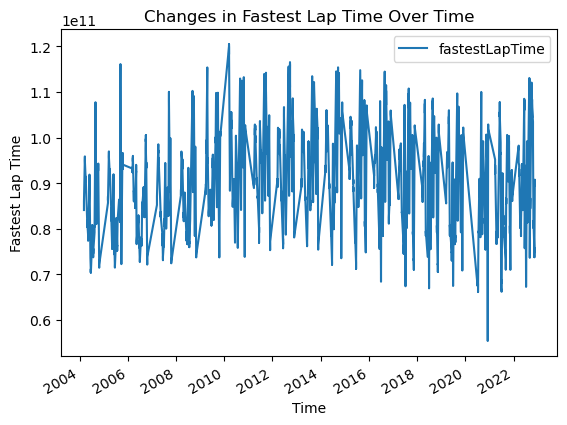

In [37]:
merged[["date","fastestLapTime"]].set_index("date").plot()
plt.xlabel("Time")
plt.ylabel("Fastest Lap Time")
plt.title("Changes in Fastest Lap Time Over Time")

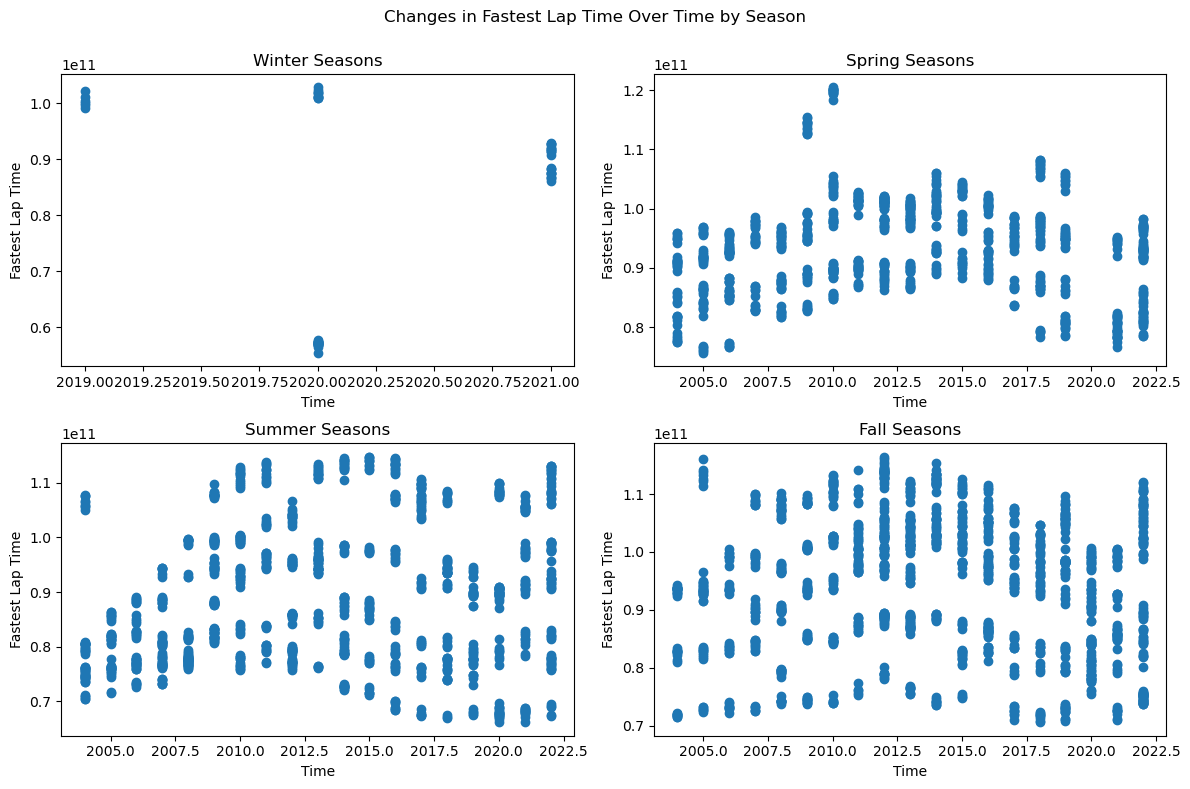

In [43]:
fig, subfigs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Changes in Fastest Lap Time Over Time by Season')
plt.tight_layout()
subfigs = subfigs.flatten()

i = 0

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_data = merged.query("Season == @season")


    # [merged['Season'] == season]

    subfigs[i].scatter(season_data["year"], season_data["fastestLapTime"])

    # season_data.set_index('date')['fastestLapTime'].plot(ax=ax)
    subfigs[i].set_xlabel("Time")
    subfigs[i].set_ylabel("Fastest Lap Time")
    subfigs[i].set_title(f"{season} Seasons")
    i += 1

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

In [44]:
#Only included these years because there is no other year with all four seasons 
filtered_merged = merged[merged['year'].isin([2019, 2021])]

merged_sorted_agg_1 = (filtered_merged.groupby(["year", "Season"])
                    .agg(mean_fastestlaptime = ('fastestLapTime','mean')))

# Display the result
display(merged_sorted_agg_1)

mean_fastestlaptime
year Season                          
2019 Fall   0 days 00:01:32.586070588
     Spring 0 days 00:01:31.057354166
     Summer 0 days 00:01:21.856934782
     Winter 0 days 00:01:40.484333333
2021 Fall   0 days 00:01:28.297461538
     Spring    0 days 00:01:23.679000
     Summer    0 days 00:01:29.644500
     Winter 0 days 00:01:29.809391304

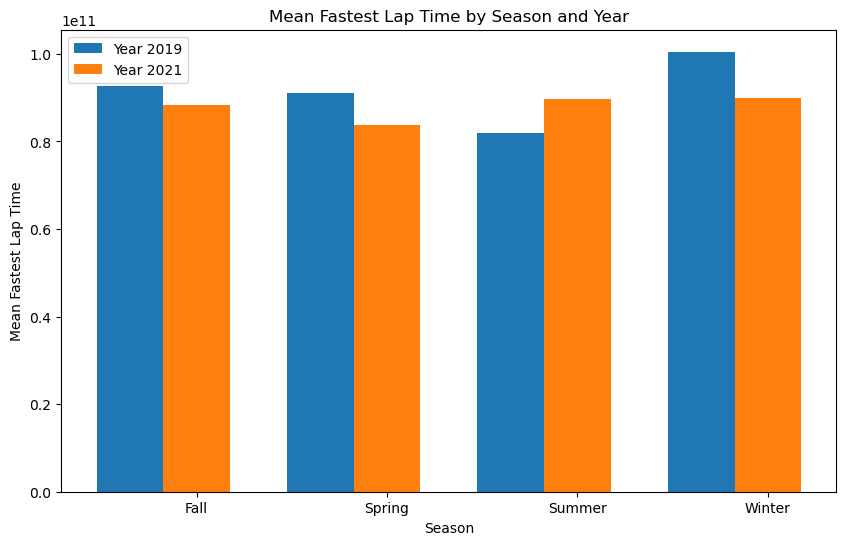

In [45]:
# Extracting unique seasons and years
seasons = merged_sorted_agg_1.index.levels[1]
years = merged_sorted_agg_1.index.levels[0]

# Setting up the positions for the bars
bar_width = 0.35
index = np.arange(len(seasons))

# Plotting the side-by-side bars
plt.figure(figsize=(10, 6))

for i, year in enumerate(years):
    data_year = merged_sorted_agg_1.loc[year]
    plt.bar(index + (i * bar_width), data_year['mean_fastestlaptime'], bar_width, label=f'Year {year}')

# Customize the plot
plt.xlabel('Season')
plt.ylabel('Mean Fastest Lap Time')
plt.title('Mean Fastest Lap Time by Season and Year')
plt.xticks(index + bar_width, seasons)
plt.legend()

# Show the plot
plt.show()

In [46]:
merged_sorted_agg_2 = (merged.groupby(["year", "name"])
                    .agg(mean_fastestlaptime = ('fastestLapTime','mean')))

# Display the result
display(merged_sorted_agg_2)

mean_fastestlaptime
year name                                                    
2004 Albert Park Grand Prix Circuit 0 days 00:01:25.080666666
     Autodromo Enzo e Dino Ferrari     0 days 00:01:21.480000
     Autodromo Nazionale di Monza   0 days 00:01:22.524727272
     Autódromo José Carlos Pace        0 days 00:01:11.804000
     Bahrain International Circuit  0 days 00:01:30.863571428
...                                                       ...
2022 Miami International Autodrome     0 days 00:01:32.735200
     Red Bull Ring                     0 days 00:01:08.498400
     Silverstone Circuit               0 days 00:01:32.038000
     Suzuka Circuit                 0 days 00:01:46.317277777
     Yas Marina Circuit             0 days 00:01:29.429818181

[343 rows x 1 columns]

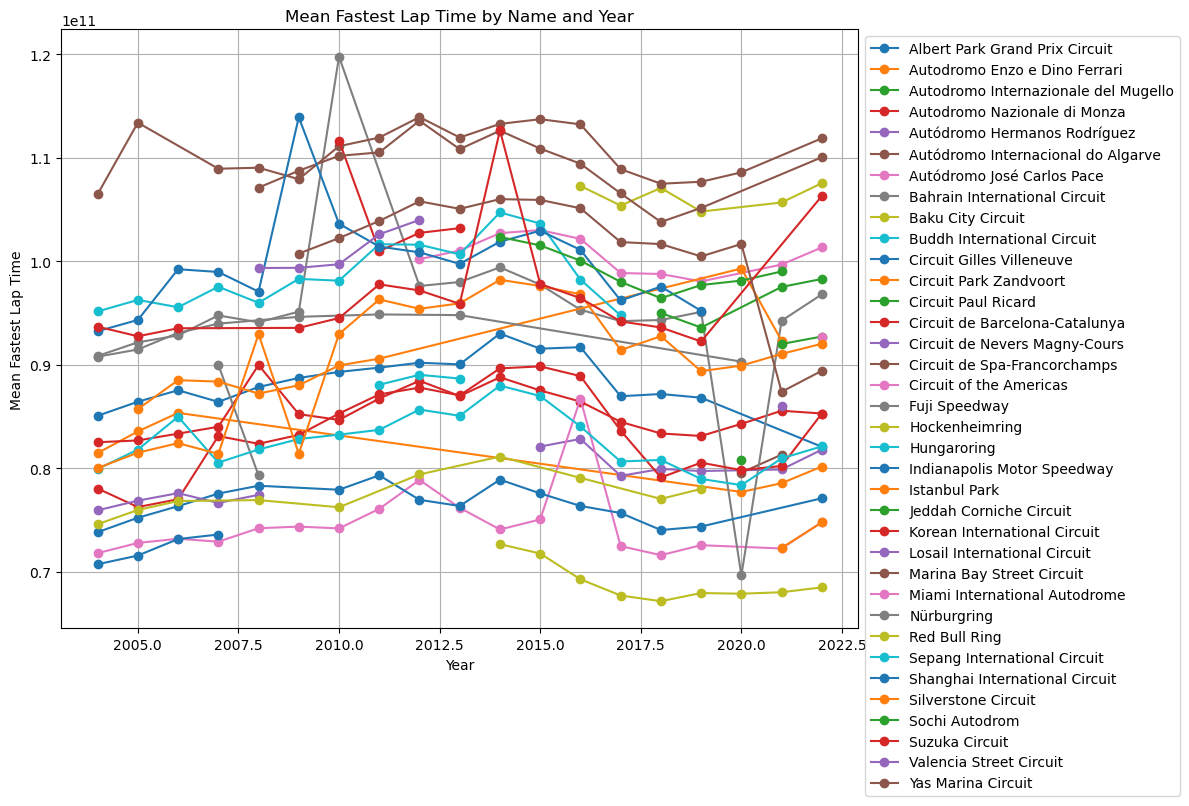

In [47]:
plt.figure(figsize=(12, 8))

for name, data in merged_sorted_agg_2.groupby(level='name'):
    plt.plot(data.index.get_level_values('year'), data['mean_fastestlaptime'], marker='o', label=name)

plt.xlabel('Year')
plt.ylabel('Mean Fastest Lap Time')
plt.title('Mean Fastest Lap Time by Name and Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True)
plt.tight_layout()
plt.show()